In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

# load the data
data = pd.read_parquet("../data/curated/data.parquet")

In [2]:
# replace 0 with small number
small_number = 1e-5
data['trip_distance'].replace(0, small_number, inplace=True)
data['trip_duration'].replace(0, small_number, inplace=True)

data.shape

(816499, 34)

In [3]:
# calculate the average profit of the taxi driver by adding the fare and tip amount per trip distance and per trip duration
data['avg_profit'] = ((data['fare_amount'] + data['tip_amount']) / data['trip_distance'] 
                      + (data['fare_amount'] + data['tip_amount']) / data['trip_duration']) / 2
                                
X = data[['trip_distance', 'passenger_count', 'trip_duration', 'TAVG', 'TMAX', 
          'TMIN', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'bad_weather']]

# Convert 'avg_profit' to binary: 1 if above median, 0 otherwise
median_profit = data['avg_profit'].median()
data['profit_label'] = (data['avg_profit'] > median_profit).astype(int)

y = data['profit_label']

In [4]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((653199, 11), (163300, 11), (653199,), (163300,))

# Random Forest Regressor

In [335]:
# define the hyperparameters and their possible values
param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the classifier
rfc = RandomForestClassifier(random_state=42)

# Set up the RandomizedSearchCV
rfc_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=10, cv=3, 
                                verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the data
rfc_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = rfc_search.best_params_
best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/subinseol/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/subinseol/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/subinseol/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   9.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   7.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   7.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   7.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   7.7s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 4.4min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.9min
[CV] END bootstrap=False, max_depth=20, max_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  38.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   7.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  28.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  27.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  29.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  32.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  31.6s
[CV] END bootstrap=True, max_depth=30, max_feat

In [345]:
# Base model
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train, y_train)
base_predictions = base_rf.predict(X_test)

print("Base Model Performance:")
print('Confusion matrix:', confusion_matrix(y_test, base_predictions))
print(classification_report(y_test, base_predictions))

# Optimized model
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train, y_train)
optimized_predictions = optimized_rf.predict(X_test)

print("\nOptimized Model Performance:")
print('Confusion matrix:', confusion_matrix(y_test, optimized_predictions))
print(classification_report(y_test, optimized_predictions))

print('Improvement of {:0.3f}%.'.format( 100 * (accuracy_score(y_test, optimized_predictions) - 
                                                accuracy_score(y_test, base_predictions)) 
                                        / accuracy_score(y_test, base_predictions)))

'''
# evaluate the base model
base_accuracy = accuracy_score(y_test, y_pred)
precision_rfc = precision_score(y_test, y_pred)
recall_rfc = recall_score(y_test, y_pred)
f1_rfc = f1_score(y_test, y_pred)
conf_matrix_rfc = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy_rfc, '%.')
print('precision:', precision_rfc)
print('recall:', recall_rfc)
print('f1:', f1_rfc)
print('Confusion matrix:', conf_matrix_rfc)
'''

Base Model Performance:
Confusion matrix: [[53860 27582]
 [18660 63198]]
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     81442
           1       0.70      0.77      0.73     81858

    accuracy                           0.72    163300
   macro avg       0.72      0.72      0.72    163300
weighted avg       0.72      0.72      0.72    163300


Optimized Model Performance:
Confusion matrix: [[47617 33825]
 [ 6741 75117]]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70     81442
           1       0.69      0.92      0.79     81858

    accuracy                           0.75    163300
   macro avg       0.78      0.75      0.74    163300
weighted avg       0.78      0.75      0.74    163300

Improvement of 4.849%.


"\n# evaluate the base model\nbase_accuracy = accuracy_score(y_test, y_pred)\nprecision_rfc = precision_score(y_test, y_pred)\nrecall_rfc = recall_score(y_test, y_pred)\nf1_rfc = f1_score(y_test, y_pred)\nconf_matrix_rfc = confusion_matrix(y_test, y_pred)\n\nprint('Accuracy:', accuracy_rfc, '%.')\nprint('precision:', precision_rfc)\nprint('recall:', recall_rfc)\nprint('f1:', f1_rfc)\nprint('Confusion matrix:', conf_matrix_rfc)\n"

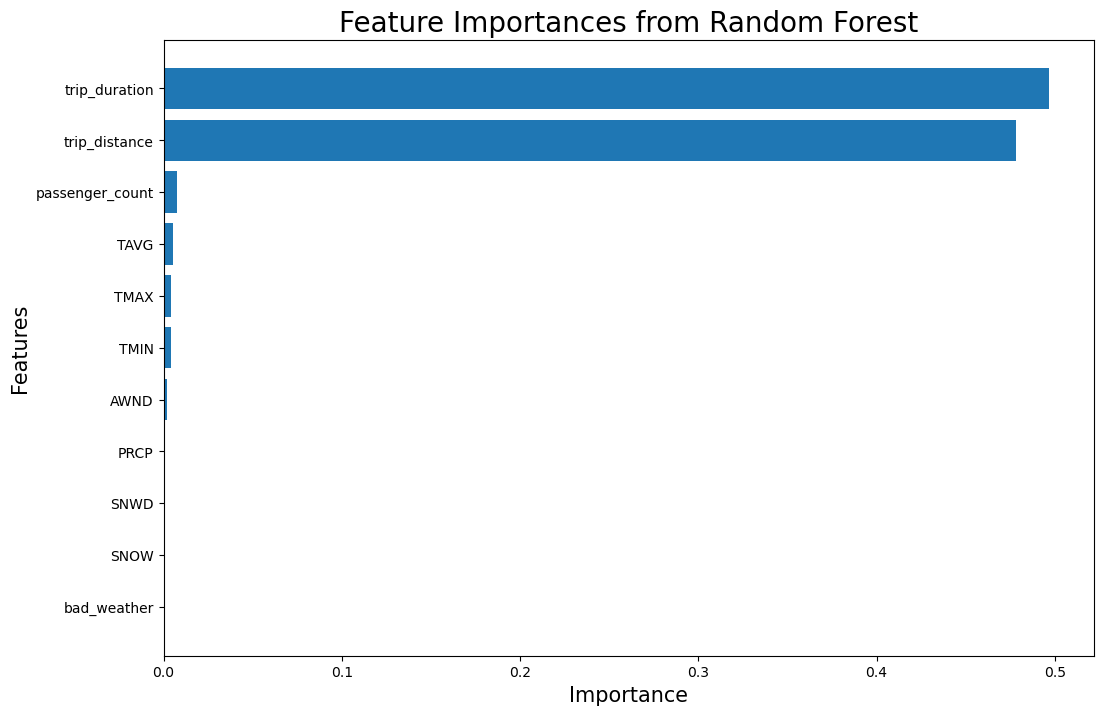

In [351]:
#  Extract feature importances and pair them with feature names for visualization
feature_data = list(zip(X.columns, optimized_rf.feature_importances_))
sorted_features = sorted(feature_data, key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.barh(features, importance, align='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Feature Importances from Random Forest', fontsize=20)
plt.gca().invert_yaxis()
plt.savefig('../plots/Feature importances from RFC')
plt.show()

In [343]:
# feature importance
feature_data = list(zip(X.columns, optimized_rf.feature_importances_))

# sort features based on importance
sorted_features = sorted(feature_data, key=lambda x: x[1], reverse=True)

features, importance = zip(*sorted_features)

# display sorted features and their importances
for feature, importance in sorted_features:
    print(f"Variable: {feature:20} Importance: {importance:.3f}")

Variable: trip_duration        Importance: 0.497
Variable: trip_distance        Importance: 0.478
Variable: passenger_count      Importance: 0.007
Variable: TAVG                 Importance: 0.005
Variable: TMAX                 Importance: 0.004
Variable: TMIN                 Importance: 0.004
Variable: AWND                 Importance: 0.002
Variable: PRCP                 Importance: 0.001
Variable: SNWD                 Importance: 0.000
Variable: SNOW                 Importance: 0.000
Variable: bad_weather          Importance: 0.000


# Logistic Regression

In [5]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy, '%.')
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)
print('Confusion matrix:', confusion)

Accuracy: 0.7030985915492958 %.
precision: 0.7046530452059162
recall: 0.7018984094407389
f1: 0.7032730299395333
Confusion matrix: [[57360 24082]
 [24402 57456]]


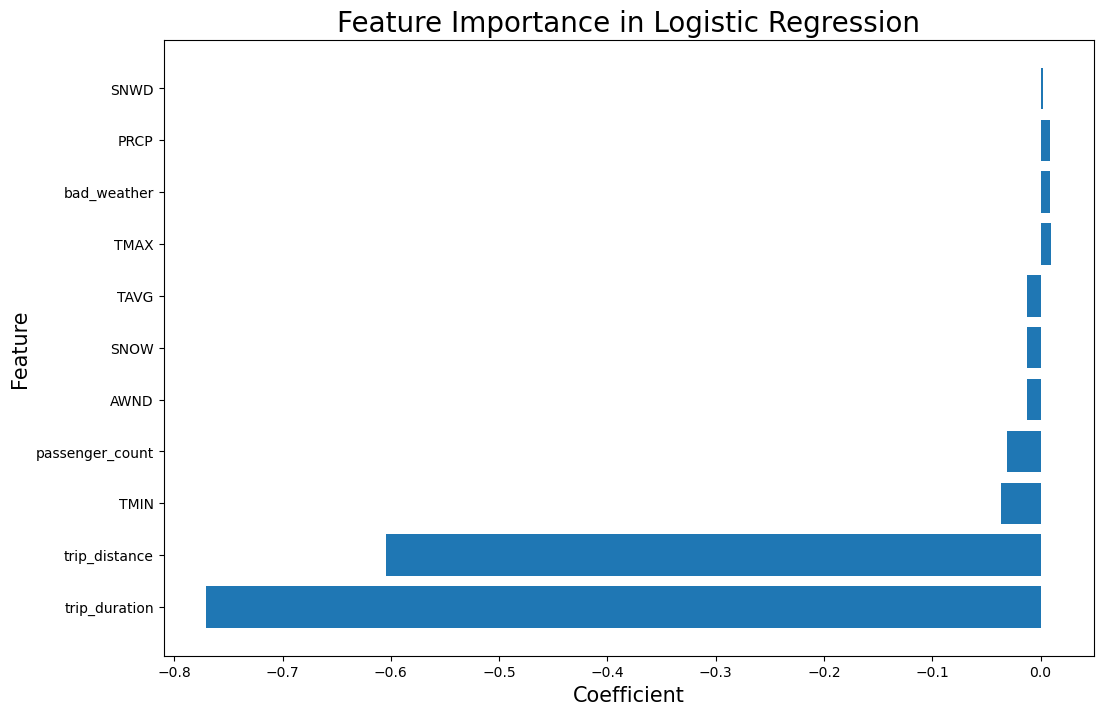

In [6]:
# Get feature names and coefficients
features = X_train.columns
coefficients = log_reg.coef_[0]

# Create a DataFrame for features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort by the absolute value of coefficients
feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Feature Importance in Logistic Regression', fontsize=20)
plt.show()